In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss

# DATASET PREPARING

In [2]:
# Wczytanie danych z pliku
save_path = "dataset.npz"
data = np.load(save_path)

# Odczytaj macierze X i y
X= data['X']
y = data['y']

actions = np.array(['hello', 'thankyou', 'love', 'friend', 'good', 'meet', 'you', 'think', 'bed', 'have'])


In [3]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# X - cechy, Y - etykiety
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

# Podział na zbiór treningowy i testowy
for train_index, test_index in sss_train.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Podział na zbiór treningowy i walidacyjny
for train_index, val_index in sss_val.split(X_train, y_train):
    X_train, X_validation = X_train[train_index], X_train[val_index]
    y_train, y_validation = y_train[train_index], y_train[val_index]


In [5]:
X_train.shape

(180, 30, 1662)

In [6]:
y_train.shape

(180, 10)

In [7]:
X_validation.shape

(60, 30, 1662)

# GRU

In [8]:

model = tf.keras.Sequential([

    tf.keras.layers.GRU(units=128, input_shape=(30, 1662), return_sequences=True),

    tf.keras.layers.GRU(units=64, return_sequences=True),

    tf.keras.layers.GRU(units=32, return_sequences=True),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128),

    tf.keras.layers.Dense(64),

    tf.keras.layers.Dense(10, activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.85),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


num_epochs = 100
batch_size = 21

history_gru = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_validation, y_validation))

model.save_weights('gru_weights.h5')



Epoch 1/100
9/9 [==============================] - 22s 604ms/step - loss: 2.3430 - categorical_accuracy: 0.1056 - val_loss: 2.2329 - val_categorical_accuracy: 0.2167
Epoch 2/100
9/9 [==============================] - 1s 137ms/step - loss: 2.1999 - categorical_accuracy: 0.2833 - val_loss: 2.0844 - val_categorical_accuracy: 0.3667
Epoch 3/100
9/9 [==============================] - 1s 135ms/step - loss: 2.0184 - categorical_accuracy: 0.3444 - val_loss: 1.9019 - val_categorical_accuracy: 0.3167
Epoch 4/100
9/9 [==============================] - 1s 144ms/step - loss: 1.8112 - categorical_accuracy: 0.3944 - val_loss: 1.7851 - val_categorical_accuracy: 0.3167
Epoch 5/100
9/9 [==============================] - 1s 137ms/step - loss: 1.6449 - categorical_accuracy: 0.3833 - val_loss: 1.5655 - val_categorical_accuracy: 0.4667
Epoch 6/100
9/9 [==============================] - 1s 137ms/step - loss: 1.5008 - categorical_accuracy: 0.4278 - val_loss: 1.4381 - val_categorical_accuracy: 0.4333
Epoch 7/1

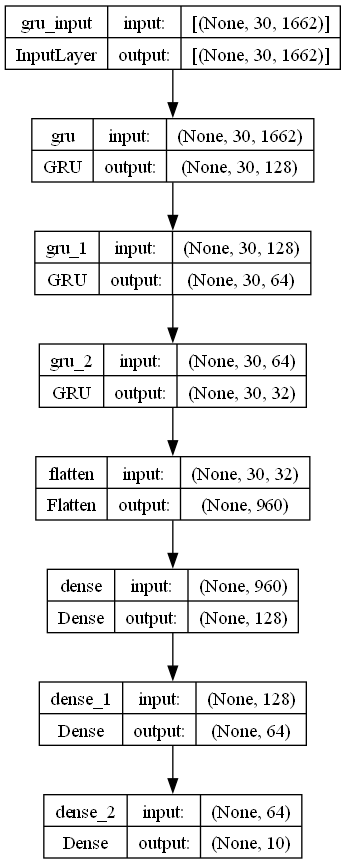

In [9]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)



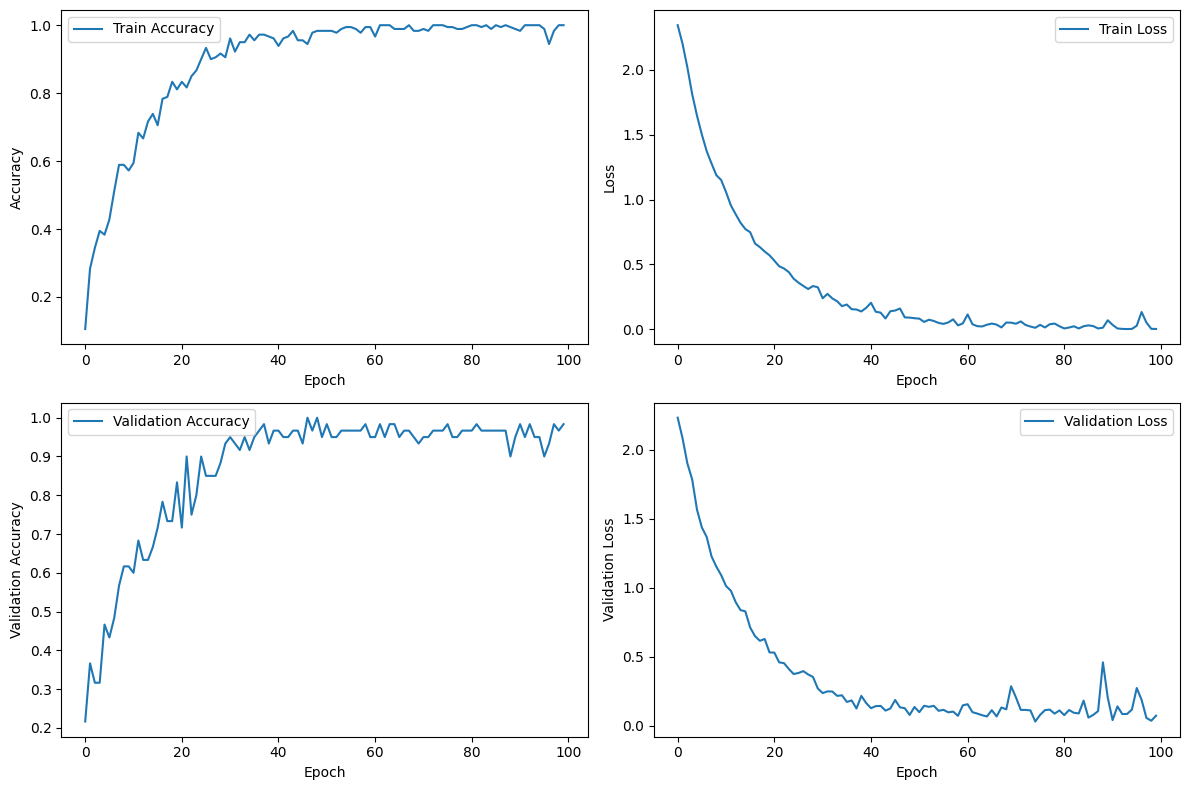

In [10]:
import matplotlib.pyplot as plt


# Wyświetlanie wykresów
plt.figure(figsize=(12, 8))

# Wykres dokładności trenowania
plt.subplot(2, 2, 1)
plt.plot(history_gru.history['categorical_accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Wykres straty trenowania
plt.subplot(2, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności walidacji
plt.subplot(2, 2, 3)
plt.plot(history_gru.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

# Wykres straty walidacji
plt.subplot(2, 2, 4)
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


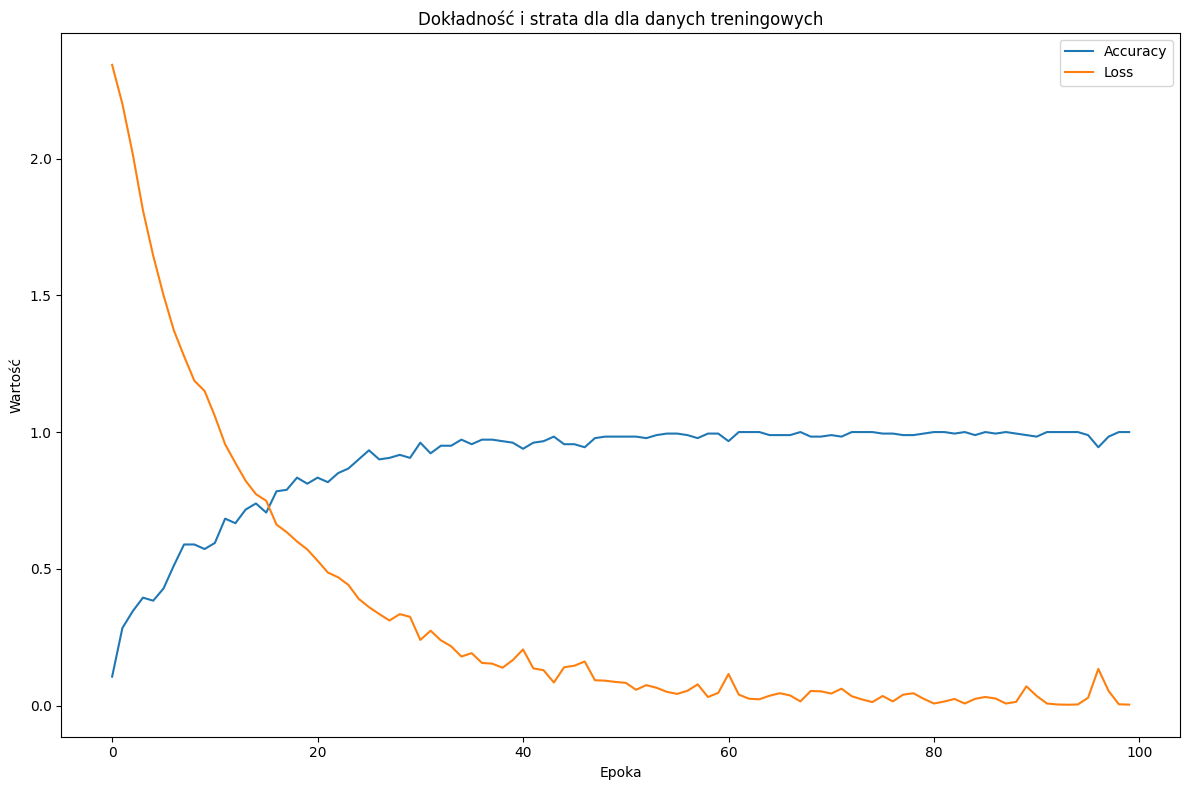

In [11]:

def plot_training_history(historyACC, historyLOSS, title):
    # Wyświetlanie wykresu
    plt.figure(figsize=(12, 8))

    # Wykres dokładności trenowania
    plt.plot(historyACC, label='Accuracy')
    
    # Wykres straty trenowania
    plt.plot( historyLOSS, label='Loss')

    plt.xlabel('Epoka')
    plt.ylabel('Wartość')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_training_history(history_gru.history['categorical_accuracy'], history_gru.history['loss'], 'Dokładność i strata dla dla danych treningowych')


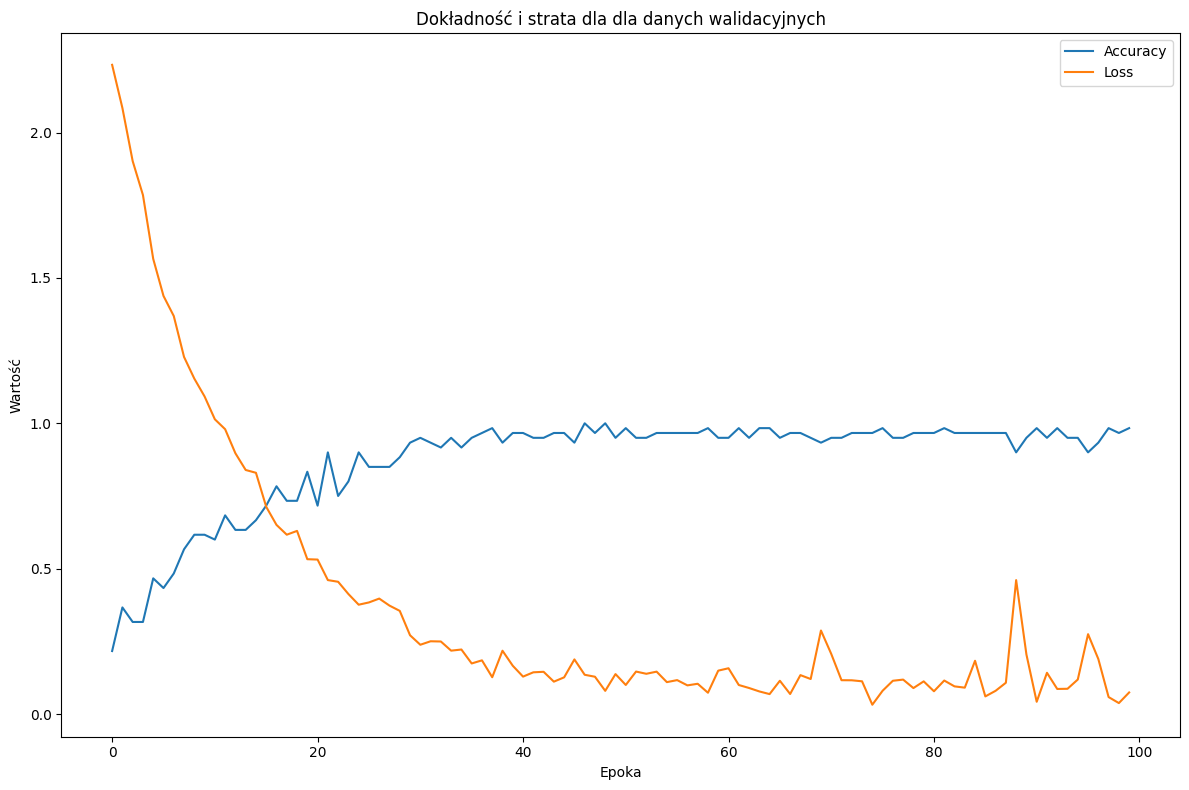

In [12]:
plot_training_history(history_gru.history['val_categorical_accuracy'], history_gru.history['val_loss'], 'Dokładność i strata dla dla danych walidacyjnych')

2/2 [==============================] - 3s 38ms/step


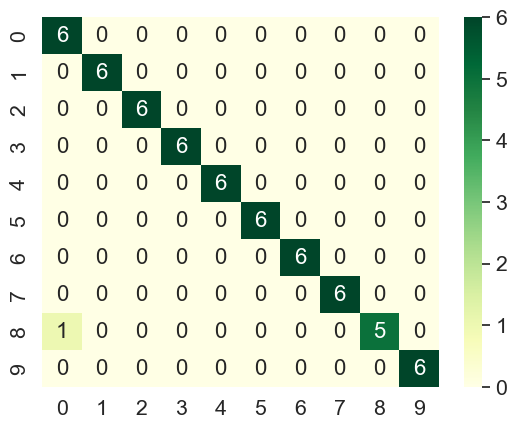

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd


y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

confusion = confusion_matrix(y_true_labels, y_pred_labels)


df_cm = pd.DataFrame(confusion, range(10), range(10))

# Ustawianie rozmiaru czcionki etykiet
sn.set(font_scale=1.4)

# Ustawianie mapy kolorów od białego do zielonego ("YlGn")
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGn")

# Pokazanie wykresu
plt.show()

In [14]:
accuracy_gru = accuracy_score(y_pred_labels, y_true_labels)
loss_gru = log_loss(y_true_labels, y_pred)
accuracy_gru

0.9833333333333333

In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support


precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average=None)

for i in range(len(precision)):
    print(f'Label {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

Label 0 - Precision: 0.8571428571428571, Recall: 1.0, F1-Score: 0.923076923076923
Label 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 2 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 3 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 4 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 5 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 6 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 7 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 8 - Precision: 1.0, Recall: 0.8333333333333334, F1-Score: 0.9090909090909091
Label 9 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


# LSTM

In [16]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(30, 1662)))
# model.add(Dropout(0.2))  # Dropout dla regularyzacji
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# model.add(Dropout(0.5))  # Dodaj Dropou
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


lstm = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation))

Epoch 1/100
6/6 [==============================] - 14s 450ms/step - loss: 2.3403 - categorical_accuracy: 0.0944 - val_loss: 2.3197 - val_categorical_accuracy: 0.1333
Epoch 2/100
6/6 [==============================] - 1s 129ms/step - loss: 2.3235 - categorical_accuracy: 0.0889 - val_loss: 2.3180 - val_categorical_accuracy: 0.1167
Epoch 3/100
6/6 [==============================] - 1s 128ms/step - loss: 2.3189 - categorical_accuracy: 0.0500 - val_loss: 2.2694 - val_categorical_accuracy: 0.1000
Epoch 4/100
6/6 [==============================] - 1s 129ms/step - loss: 2.2632 - categorical_accuracy: 0.0889 - val_loss: 2.2223 - val_categorical_accuracy: 0.1000
Epoch 5/100
6/6 [==============================] - 1s 124ms/step - loss: 2.2044 - categorical_accuracy: 0.1222 - val_loss: 2.0851 - val_categorical_accuracy: 0.2667
Epoch 6/100
6/6 [==============================] - 1s 120ms/step - loss: 2.0452 - categorical_accuracy: 0.2000 - val_loss: 1.8993 - val_categorical_accuracy: 0.1833
Epoch 7/1

In [17]:
model.save_weights('lstm_weights.h5')

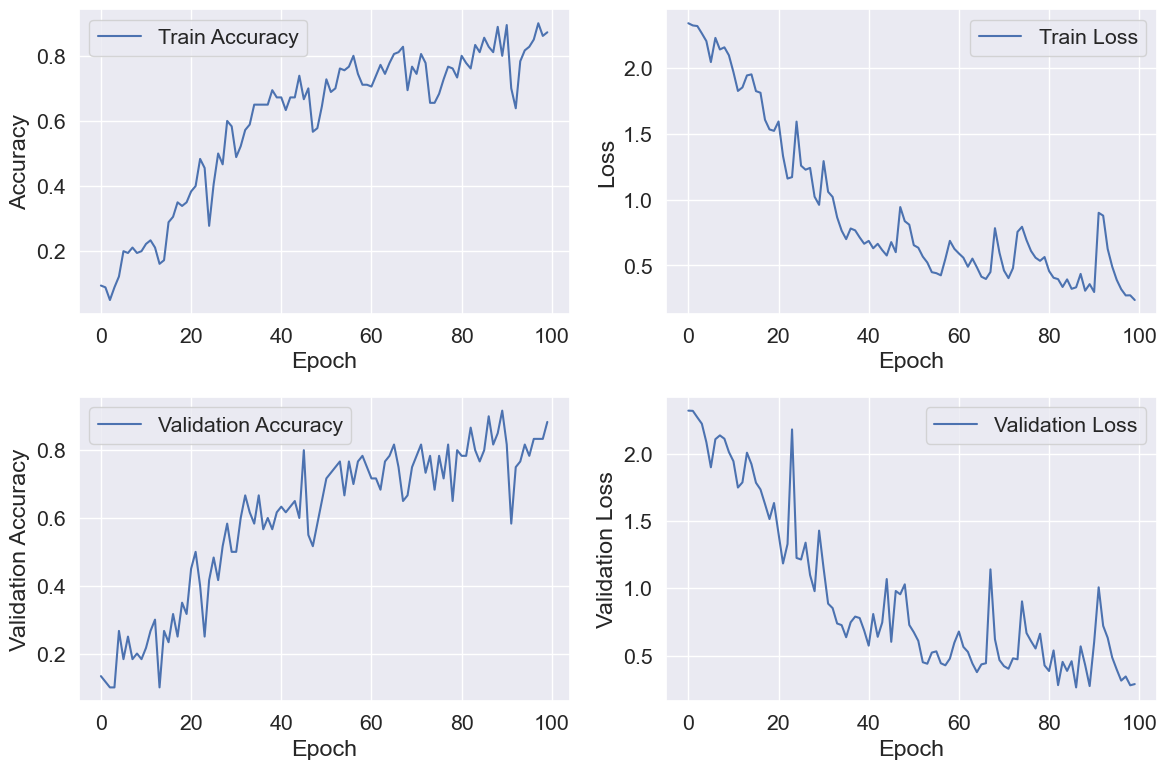

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
plt.plot(lstm.history['categorical_accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(lstm.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(lstm.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

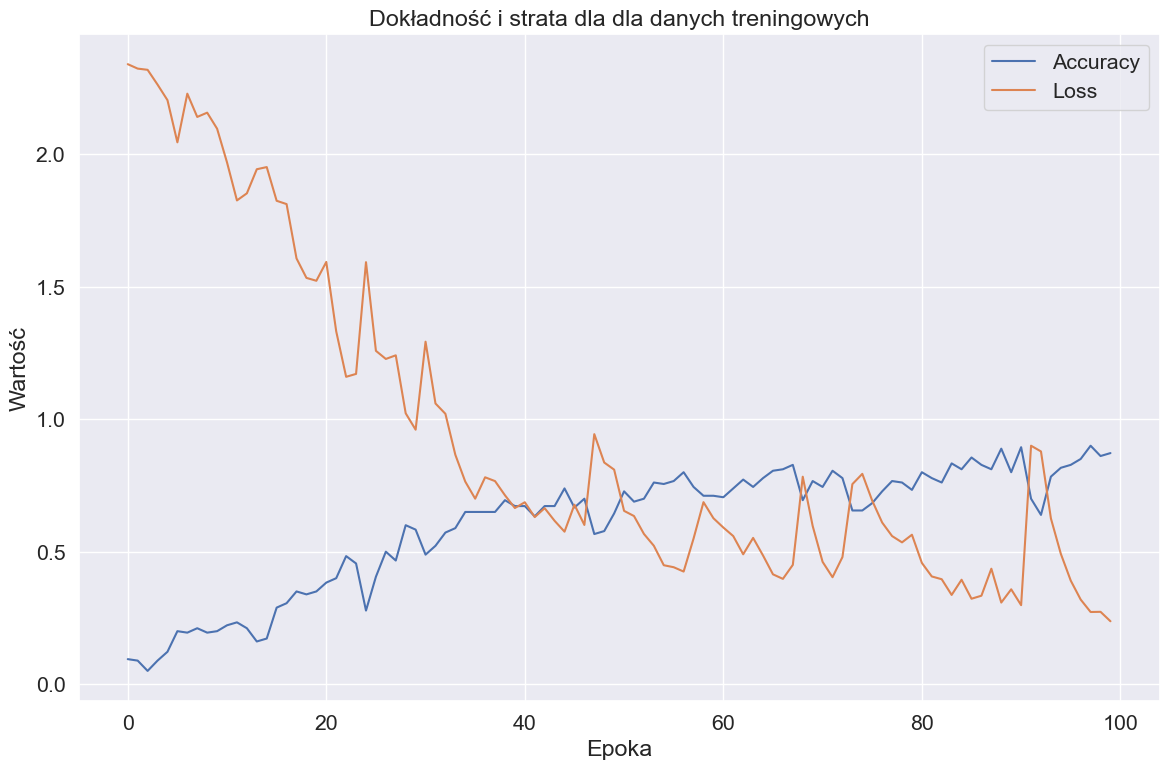

In [19]:
plot_training_history(lstm.history['categorical_accuracy'], lstm.history['loss'], 'Dokładność i strata dla dla danych treningowych')

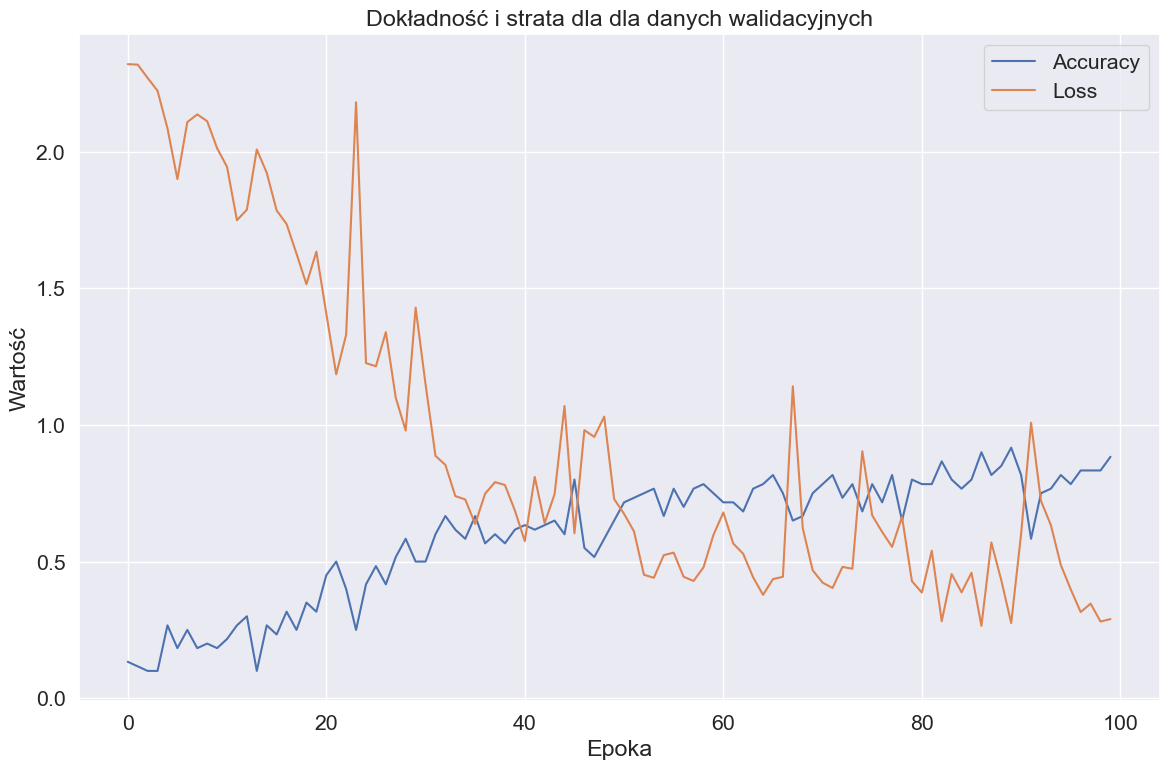

In [20]:
plot_training_history(lstm.history['val_categorical_accuracy'], lstm.history['val_loss'], 'Dokładność i strata dla dla danych walidacyjnych')


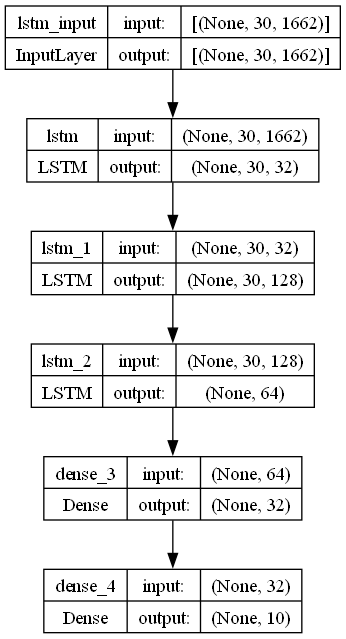

In [21]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

2/2 [==============================] - 1s 37ms/step


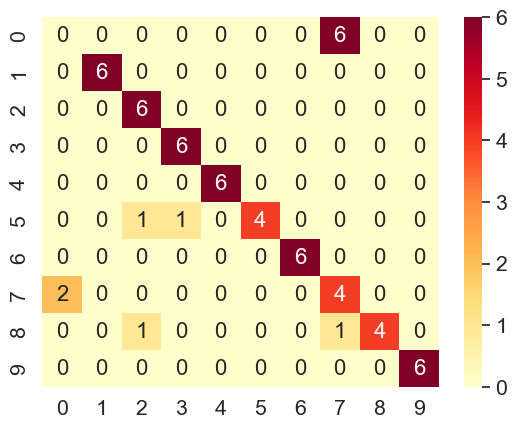

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score



y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

confusion = confusion_matrix(y_true_labels, y_pred_labels)

df_cm_lstm = pd.DataFrame(confusion, range(10), range(10))

# Ustawianie rozmiaru czcionki etykiet
sn.set(font_scale=1.4)

# Ustawianie mapy kolorów od białego do zielonego ("YlGnBu_r")
sn.heatmap(df_cm_lstm, annot=True, annot_kws={"size": 16}, cmap="YlOrRd")

# Pokazanie wykresu
plt.show()

In [23]:
accuracy_lstm = accuracy_score(y_pred_labels, y_true_labels)
loss_lstm = log_loss(y_true_labels, y_pred)
loss_lstm

0.7947165042506771

In [24]:

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_pred_labels, y_true_labels, average=None)

# Wyniki dla każdej etykiety
for i in range(len(precision)):
    print(f'Label {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

Label 0 - Precision: 0.0, Recall: 0.0, F1-Score: 0.0
Label 1 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 2 - Precision: 1.0, Recall: 0.75, F1-Score: 0.8571428571428571
Label 3 - Precision: 1.0, Recall: 0.8571428571428571, F1-Score: 0.923076923076923
Label 4 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 5 - Precision: 0.6666666666666666, Recall: 1.0, F1-Score: 0.8
Label 6 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 7 - Precision: 0.6666666666666666, Recall: 0.36363636363636365, F1-Score: 0.4705882352941177
Label 8 - Precision: 0.6666666666666666, Recall: 1.0, F1-Score: 0.8
Label 9 - Precision: 1.0, Recall: 1.0, F1-Score: 1.0


# Porównanie

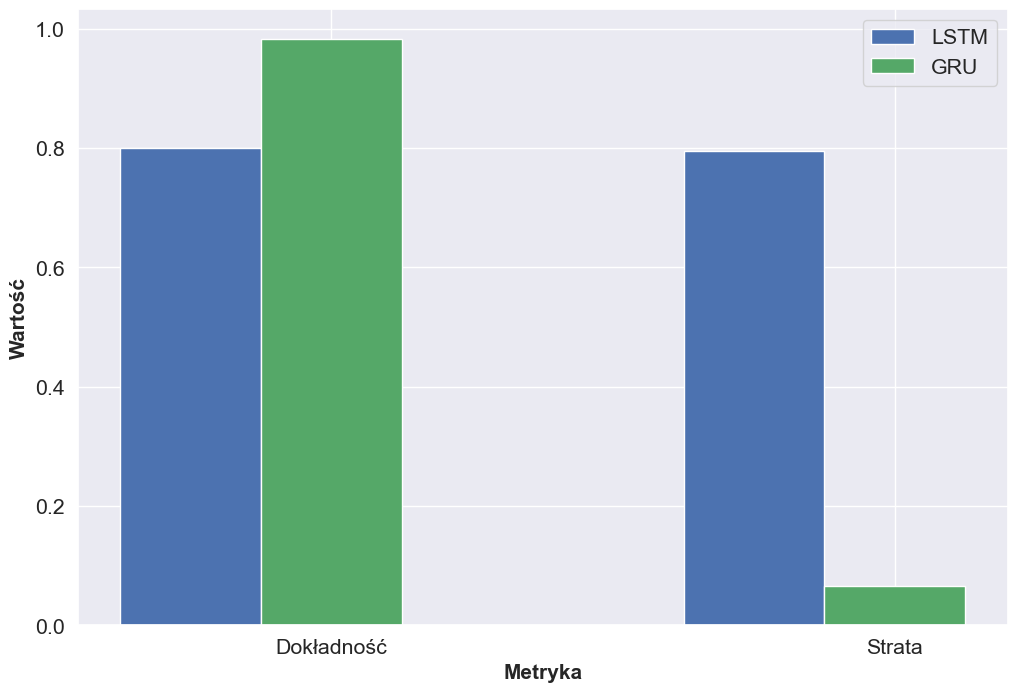

In [25]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
LSTM= [accuracy_lstm, loss_lstm] 
GRU = [accuracy_gru, loss_gru] 
 
# Set position of bar on X axis 
br1 = np.arange(len(LSTM)) 
br2 = [x + barWidth for x in br1] 

# Make the plot
plt.bar(br1, LSTM, color ='b', width = barWidth, 
        label ='LSTM') 
plt.bar(br2, GRU, color ='g', width = barWidth, 
        label ='GRU') 

 
# Adding Xticks 
plt.xlabel('Metryka', fontweight ='bold', fontsize = 15) 
plt.ylabel('Wartość', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(LSTM))], 
        ['Dokładność', 'Strata'])
 
plt.legend()
plt.show()


# KFOLDS

In [26]:
# # gru
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Flatten
# import matplotlib.pyplot as plt

# k = 5

# kf = KFold(n_splits=k, shuffle=True)


# accuracies = []
# train_accuracies = []
# val_accuracies = []

# for train_index, val_index in kf.split(X):

#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     model = Sequential()
#     model.add(GRU(units=128, input_shape=(30, 1662), return_sequences=True))
#     model.add(GRU(units=64, return_sequences=True))
#     model.add(GRU(units=32, return_sequences=True))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(actions.shape[0], activation='softmax'))

#     model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#     history_gru = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)

#     y_pred = model.predict(X_val)

#     accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
#     accuracies.append(accuracy)

#     train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
#     train_accuracies.append(train_accuracy)

#     val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
#     val_accuracies.append(val_accuracy)


# mean_accuracy = np.mean(accuracies)
# print(f'Average cross-validation accuracy (k={k}): {mean_accuracy} a dla pojedycznych k: {accuracies}')

# differences = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
# mean_difference = np.mean(differences)
# print(f'Average difference between training and validation accuracy: {mean_difference}')

# plt.plot(history_gru.history['categorical_accuracy'], label='Training Accuracy')
# plt.plot(history_gru.history['val_categorical_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [27]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
# import matplotlib.pyplot as plt


# k = 5

# kf = KFold(n_splits=k, shuffle=True)

# accuracies = []
# train_accuracies = []
# val_accuracies = []
# histories = [] 


# model = Sequential()
# model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# for train_index, val_index in kf.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # model = Sequential()
#     # model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
#     # model.add(LSTM(128, return_sequences=True, activation='relu'))
#     # model.add(LSTM(64, return_sequences=False, activation='relu'))
#     # model.add(Dense(32, activation='relu'))
#     # model.add(Dense(actions.shape[0], activation='softmax'))    
#     # model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


#     history_lstm = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
#     histories.append(history_lstm)
#     y_pred = model.predict(X_val)
#     accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
#     accuracies.append(accuracy)

#     train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
#     train_accuracies.append(train_accuracy)

# mean_accuracy = np.mean(accuracies)
# print(f'Średnia dokładność walidacji krzyżowej (k={k}): {mean_accuracy} a całość {accuracies}')

# differences = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
# mean_difference = np.mean(differences)
# print(f'Średnia różnica między treningową a walidacyjną dokładnością: {mean_difference}')

# avg_history = {}
# for key in histories[0].history.keys():
#     avg_history[key] = np.mean([fold.history[key] for fold in histories], axis=0)

# plt.plot(avg_history['categorical_accuracy'], label='Training Accuracy')
# plt.plot(avg_history['val_categorical_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
